In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
import string

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer

from sklearn.naive_bayes import BernoulliNB

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adagrad


plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

Using TensorFlow backend.


# Analysis of Grant data

In [2]:
df = pd.read_csv('scraped_data/grants_gov.csv', sep='~')

In [3]:
df.head()

,OpportunityID,OpportunityTitle,OpportunityNumber,OpportunityCategory,FundingInstrumentType,CategoryOfFundingActivity,CategoryExplanation,CFDANumbers,EligibleApplicants,AdditionalInformationOnEligibility,...,Version,CostSharingOrMatchingRequirement,ArchiveDate,GrantorContactEmail,GrantorContactEmailDescription,GrantorContactText,AdditionalInformationURL,AdditionalInformationText,OpportunityCategoryExplanation,CloseDateExplanation
0,262148,Establishment of the Edmund S. Muskie Graduate...,SCAPPD-14-AW-161-SCA-08152014,D,CA,O,Public Diplomacy,19.040,25,Eligibility for U.S. institutions is limited t...,...,Synopsis 2,No,10042014.0,DelageEM@state.gov,Inquiries,"Ellen Delage, Bureau of South and Central Asia...",NaN,NaN,NaN,NaN
1,262149,Eradication of Yellow Crazy Ants on Johnston A...,F14AS00402,D,CA,"AG,ENV,NR",NaN,15.608,99,The recipient has already been selected for th...,...,Synopsis 1,No,8232014.0,Connie_Sauer@fws.gov,Connie_Sauer@fws.gov,"Connie Sauer, 503-490-0827&lt;br/&gt;Connie_Sa...",http://www.grants.gov/,http://www.grants.gov/,NaN,NaN
2,131073,"Cooperative Ecosystem Studies Unit, Piedmont S...",G12AS20003,D,CA,ST,NaN,15.808,25,This financial assistance opportunity is being...,...,Synopsis 2,No,12172011.0,fgraves@usgs.gov,fgraves@usgs.gov,"Faith Graves, 703-648-7356&lt;br/&gt;fgraves@u...",http://www.grants.gov/,http://www.grants.gov/,NaN,NaN
3,196613,OVW FY 2012 Training and Technical Assistance ...,OVW-2012-3380,D,CA,LJL,NaN,16.526,"06,12",NaN,...,Synopsis 1,No,11142012.0,Christina.Murray@usdoj.gov,Christina.Murray@usdoj.gov,Christina Murray &lt;br/&gt;Phone 202-307-0344,http://www.ovw.usdoj.gov/docs/grantee-reportin...,OVW FY 2012 Training and Technical Assistance ...,CategoryExplanation,NaN
4,65553,Affordable Care Act (ACA): Childhood Obesity R...,RFA-DP-11-007,D,CA,HL,NaN,93.535,99,NaN,...,Synopsis 10,No,5182011.0,pgotim@cdc.gov,General Email,Centers for Disease Control and Prevention (CD...,Please click on Full Announcement at the top o...,Please click on Full Announcement at the top o...,NaN,On-time submission requires that electronic ap...


In [4]:
df.columns.values

array(['OpportunityID', 'OpportunityTitle', 'OpportunityNumber',
       'OpportunityCategory', 'FundingInstrumentType',
       'CategoryOfFundingActivity', 'CategoryExplanation', 'CFDANumbers',
       'EligibleApplicants', 'AdditionalInformationOnEligibility',
       'AgencyCode', 'AgencyName', 'PostDate', 'CloseDate',
       'LastUpdatedDate', 'AwardCeiling', 'AwardFloor',
       'EstimatedTotalProgramFunding', 'ExpectedNumberOfAwards',
       'Description', 'Version', 'CostSharingOrMatchingRequirement',
       'ArchiveDate', 'GrantorContactEmail',
       'GrantorContactEmailDescription', 'GrantorContactText',
       'AdditionalInformationURL', 'AdditionalInformationText',
       'OpportunityCategoryExplanation', 'CloseDateExplanation'], dtype=object)

## Funding Categories

In [5]:
category_funding_d = {'ACA': 'Affordable Care Act',
 'AG': 'Agriculture',
 'AR': 'Arts',
 'BC': 'Business and Commerce',
 'CD': 'Community Development',
 'CP': 'Consumer Protection',
 'DPR': 'Disaster Prevention and Relief',
 'ED': 'Education',
 'ELT': 'Employment, Labor and Training',
 'EN': 'Energy',
 'ENV': 'Environment',
 'FN': 'Food and Nutrition',
 'HL': 'Health',
 'HO': 'Housing',
 'HU': 'Humanities',
 'IS': 'Information and Statistics',
 'ISS': 'Income Security and Social Services',
 'LJL': 'Law, Justice and Legal Services',
 'NR': 'Natural Resources',
 'O': 'Other',
 'RA': 'Recovery Act',
 'RD': 'Regional Development',
#  'ST': 'Science and Technology and other Research and Development', #too long for the plot
 'ST': 'Science and Technology and R and D',
 'T': 'Transportation'}

In [6]:
def map_category_funding(s):
    return [category_funding_d[w] for w in s.split(',')]

funding_activities = [w for l in df['CategoryOfFundingActivity'].apply(map_category_funding).values for w in l]
df['CategoryFullTitle'] = df['CategoryOfFundingActivity'].apply(map_category_funding)

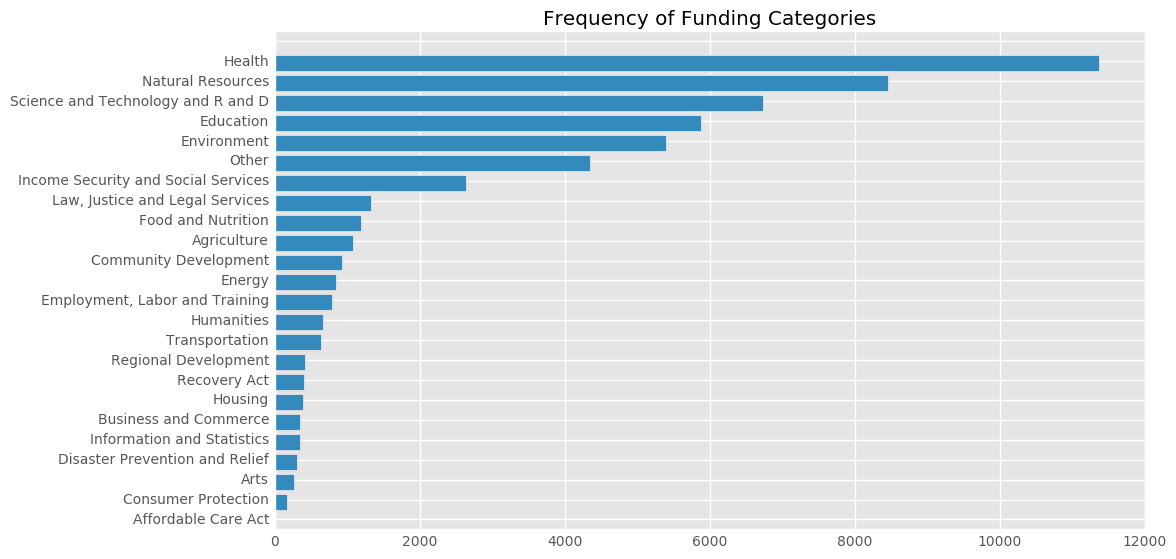

In [7]:
categories_freq = nltk.FreqDist(funding_activities).most_common(24)[::-1]
categories = []
freqs = []

for category, freq in categories_freq:
    categories.append(category)
    freqs.append(freq)
plt.barh(range(len(categories)), freqs)
ypos = np.arange(25) + 0.5
plt.yticks(ypos, categories)
plt.title('Frequency of Funding Categories')
plt.show()

## Opportunity Title

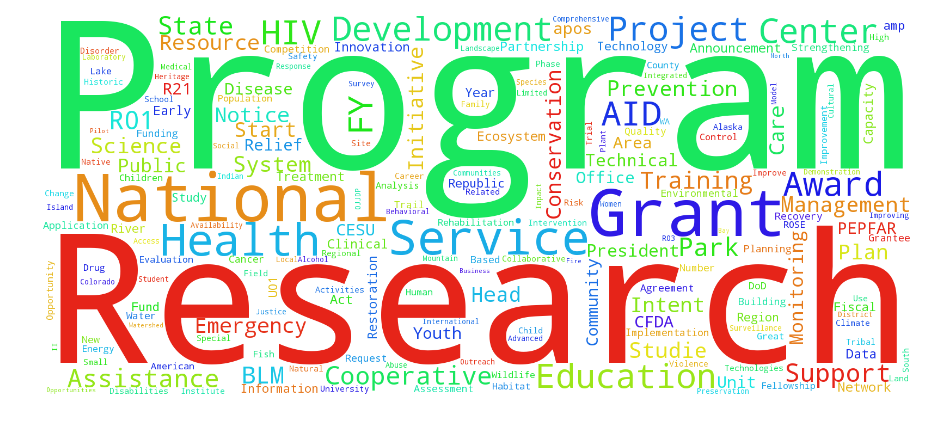

In [8]:
wc = WordCloud(background_color='white', width=1600, height=700, random_state=27).generate(' '.join(df['OpportunityTitle'].values))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Agency Name

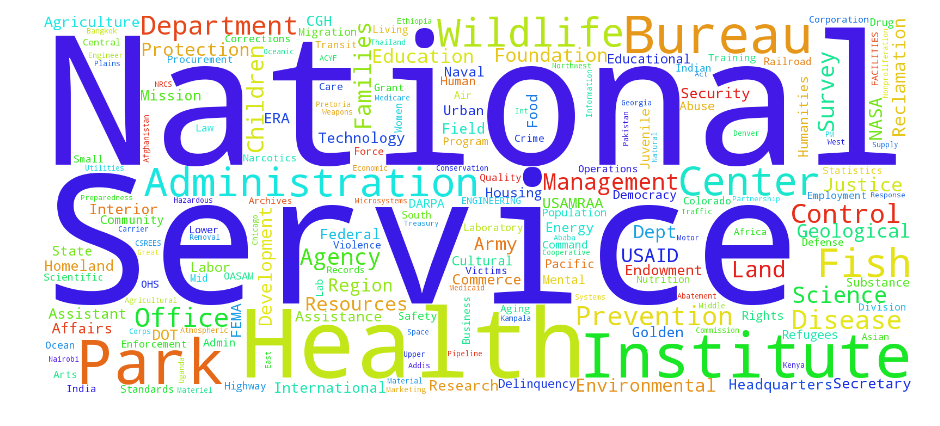

In [22]:
wc = WordCloud(background_color='white', width=1600, height=700, random_state=27)\
               .generate(' '.join(df['AgencyName'][~(df['AgencyName'].isnull())].values))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Description

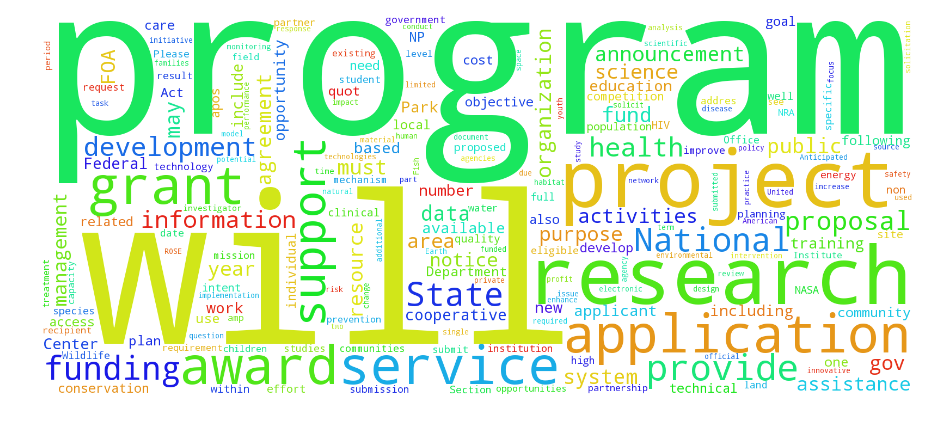

In [45]:
wc = WordCloud(background_color='white', width=1600, height=700, random_state=27)\
               .generate(' '.join(df['Description'][~(df['Description'].isnull())].values))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Percent of grants that either mistakenly have 0 as their monetary value or are giving any money

In [32]:
award_ceiling = df['AwardCeiling'][~df['AwardCeiling'].isnull()]

np.mean(award_ceiling < 1)

0.17591428742443288

### Heavily skewed mean

In [35]:
np.mean(award_ceiling_non_zero)

36473349509.94712

### More realisitc median

In [40]:
np.median(award_ceiling_non_zero)

284100.0

### Seems like someone has a lot of money to give

In [38]:
np.max(award_ceiling_non_zero)

999999999999999.0

In [39]:
np.min(award_ceiling_non_zero)

2.0

## Distribution of award_ceilings below a million

(array([ 8318.,  3753.,  2639.,  1288.,  1868.,   618.,   270.,   665.,
          424.,   288.]),
 array([  2.00000000e+00,   1.00001700e+05,   2.00001400e+05,
          3.00001100e+05,   4.00000800e+05,   5.00000500e+05,
          6.00000200e+05,   6.99999900e+05,   7.99999600e+05,
          8.99999300e+05,   9.99999000e+05]),
 <a list of 10 Patch objects>)

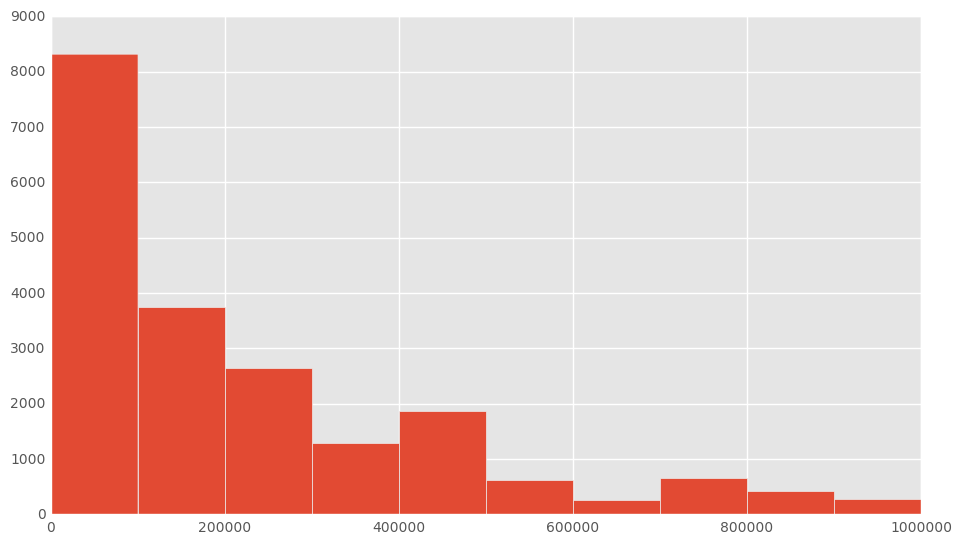

In [43]:
award_ceiling_non_zero = award_ceiling[(award_ceiling > 1) & (award_ceiling_non_zero < 1000000)]
plt.hist(award_ceiling_non_zero, bins=10)

## Was wondering how predictive the title is of the funding category

So I threw together a model that:

- Takes in the title of the grant

- Outputs a prediction of the category/label of the grant.

For instance as below, it'll take in this title and try to predict the category:

- 'Cooperative Ecosystem Studies Unit, Piedmont South Atlantic Coast CESU'

- 'ST' which corresponds to 'Science and Technology and other Research and Development'

Tried out Naive Bayes then Neural Nets for a better result. Overall the model is weak ($78\%$ on testing) but can definitely be improved by:

- Tuning the neural network

- Making some real features (besides just looking at whether a word is contained in the title or not)
    - Spatial positioning of words/types of words used (noun/verb)/combination of words used together
    - Using word2vec to map the words to a sentiment vector space (not too familiar with this and I need to read more on this)
    
- Feature selection because the training set has a $97\%$ accuracy.
    
- Incorporating other variables besides just the title such as description, grant floor and ceiling


This isn't directly related to the main problem of recommendation systems but might be used to create labels for grants that are unlabeled which would help for filling in missing data. Or maybe some grants are labeled as one thing but are on the border of being on another label which could point this grant towards a different range of faculty members.

In [12]:
df['OpportunityTitle'][2]

'Cooperative Ecosystem Studies Unit, Piedmont South Atlantic Coast CESU'

In [11]:
df['CategoryOfFundingActivity'][2]

'ST'

In [7]:
train_set_size = 25000

In [8]:
remove_words = set(stopwords.words('english') + list(string.punctuation))

word_mass = [w for w in nltk.word_tokenize(' '.join(df['OpportunityTitle'].values[:train_set_size]).lower()) 
             if w not in remove_words]
title_word_freq = nltk.FreqDist(word_mass)

word_features = [t[0] for t in title_word_freq.most_common(5000)]

In [9]:
word_features[:10]

['program',
 'research',
 'national',
 'health',
 'fy',
 'development',
 'grants',
 'services',
 'award',
 'education']

In [10]:
def generate_features(title):
    title_tokens = set([w for w in nltk.word_tokenize(title.lower()) if w not in remove_words])
    features = [(word in title_tokens) * 1 for word in word_features]
    return features
    
#only take those with 1 label
bool_filter = df['CategoryOfFundingActivity'].apply(lambda s:',' not in s)

rows = df[bool_filter]['OpportunityTitle'].apply(generate_features)

model_df = pd.DataFrame(list(rows), columns=word_features)
target_df = df['CategoryFullTitle'][bool_filter].apply(lambda l:l[0])

train_X = model_df[:train_set_size]
train_Y = target_df[:train_set_size]
test_X = model_df[train_set_size:]
test_Y = target_df[train_set_size:]

In [11]:
len(train_X), len(test_X)

(25000, 8866)

## Naive Bayes (Bernoulli)

In [ ]:
nb = BernoulliNB()
nb.fit(train_X, train_Y)

### Checking to make sure there's no class imbalance issues

In [162]:
nltk.FreqDist(nb.predict(test_X))

FreqDist({'Agriculture': 11,
          'Education': 428,
          'Employment, Labor and Training': 3,
          'Energy': 67,
          'Environment': 408,
          'Health': 1971,
          'Housing': 1,
          'Humanities': 38,
          'Income Security and Social Services': 89,
          'Law, Justice and Legal Services': 248,
          'Natural Resources': 2548,
          'Other': 1281,
          'Recovery Act': 1,
          'Science and Technology and R and D': 1718,
          'Transportation': 54})

In [152]:
nb.score(train_X, train_Y)

0.73299999999999998

In [153]:
nb.score(test_X, test_Y)

0.68711933228062261

## Neural Nets

In [61]:
# label_encoder = LabelEncoder()
# label_encoder.fit(train_Y)
# labeled_train_Y = label_encoder.transform(train_Y)
# labeled_test_Y = label_encoder.transform(test_Y)
# # one_hot = OneHotEncoder()
# # one_hot.fit(labeled_train_Y)
# # one_hot_train_Y = one_hot.transform(labeled_train_Y)
# # one_hot_test_Y = one_hot.transform(labeled_test_Y)
# one_hot_train_Y = pd.get_dummies(labeled_train_Y)
# one_hot_test_Y = pd.get_dummies(labeled_test_Y)

lb = LabelBinarizer()
one_hot_train_Y = lb.fit_transform(train_Y)
one_hot_test_Y = lb.transform(test_Y)

In [62]:
one_hot_train_Y.shape

(25000, 24)

In [88]:
np.random.seed(27)

nn = Sequential([
    Dense(1000, input_dim=len(train_X.columns.values), 
          init='normal', activation='relu'),
    Dense(1000, init='normal', activation='relu'),
    Dense(24, init='normal')
])

nn.compile(optimizer='rmsprop',
              loss='mse')


nn.fit(train_X.values, one_hot_train_Y, 
       nb_epoch=5, batch_size=100, verbose=True)

Epoch 1/4
25000/25000 [==============================] - 61s - loss: 0.0237    
Epoch 2/4
25000/25000 [==============================] - 64s - loss: 0.0118    
Epoch 3/4
25000/25000 [==============================] - 59s - loss: 0.0080    
Epoch 4/4
25000/25000 [==============================] - 54s - loss: 0.0059    


4 epochs

In [89]:
train_preds = nn.predict(train_X.values)
print('Training Accuracy: {}'.format(sum(lb.inverse_transform(train_preds) == train_Y)/len(train_Y)))

test_preds = nn.predict(test_X.values)
print('Training Accuracy: {}'.format(sum(lb.inverse_transform(test_preds) == test_Y)/len(test_Y)))

Training Accuracy: 0.96348
Training Accuracy: 0.7802842318971351


5 epochs

In [82]:
train_preds = nn.predict(train_X.values)
print('Training Accuracy: {}'.format(sum(lb.inverse_transform(train_preds) == train_Y)/len(train_Y)))

test_preds = nn.predict(test_X.values)
print('Training Accuracy: {}'.format(sum(lb.inverse_transform(test_preds) == test_Y)/len(test_Y)))

Training Accuracy: 0.97116
Training Accuracy: 0.78287841191067


# Analysis of Faculty Profiles data

In [48]:
df_faculty = pd.read_csv('scraped_data/faculty_profiles.csv', sep='~')

In [49]:
df_faculty.head()

,faculty_name,faculty_profile_url,l_expertise,department,title_name,faculty_site_url,lab_url,faculty_email,description,description_links,...,link_to_news_3,description_teaser_3,article_date_4,title_of_news_4,link_to_news_4,description_teaser_4,article_date_5,title_of_news_5,link_to_news_5,description_teaser_5
0,David A. Aaker,/faculty/david-aaker,"business,marketing,branding",Haas School of Business,Professor of Marketing and Public Policy,http://www.haas.berkeley.edu/faculty/aaker.html,http://groups.haas.berkeley.edu/marketing/,aaker@haas.berkeley.edu,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Pieter Abbeel,/faculty/pieter-abbeel,"robotics,machine learning",Division of Computer Science/EECS,Professor,http://www.cs.berkeley.edu/~pabbeel,NaN,pabbeel@cs.berkeley.edu,Robotics and Machine Learning.,NaN,...,/news/new-deep-learning-technique-enables-robo...,UC Berkeley researchers have developed algor...,"December 17, 2012",Big NSF grant funds research into training ro...,/news/big-nsf-grant-funds-research-training-ro...,"What if robots and humans, working together,...","August 23, 2011",UC Berkeley robotics expert named among world...,/news/uc-berkeley-robotics-expert-named-among-...,"Pieter Abbeel, a UC Berkeley, professor know..."
2,Elizabeth Abel,/faculty/elizabeth-abel,"feminist theory,psychoanalysis,Virginia Woolf,...",Department of English,Professor of English,http://english.berkeley.edu/profiles/5,NaN,eabel@uclink.berkeley.edu,Elizabeth Abel's general research interest is...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Dor Abrahamson,/faculty/dor-abrahamson,"mathematical cognition,design-based research,m...",Graduate School of Education,Associate Professor of Cognition and Development,http://gse.berkeley.edu/people/dor-abrahamson,http://edrl.berkeley.edu/,dor@berkeley.edu,Dor Abrahamson studies the process of mathema...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Norman Abrahamson,/faculty/norman-abrahamson,"civil and environmental engineering,earthquake...",Department of Civil and Environmental Engineering,Adjunct Professor of Civil and Environmental E...,http://www.ce.berkeley.edu/faculty/faculty.php...,NaN,naa3@earthlink.net,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_faculty.columns.values

array(['faculty_name', 'faculty_profile_url', 'l_expertise', 'department',
       'title_name', 'faculty_site_url', 'lab_url', 'faculty_email',
       'description', 'description_links', 'article_date_1',
       'title_of_news_1', 'link_to_news_1', 'description_teaser_1',
       'article_date_2', 'title_of_news_2', 'link_to_news_2',
       'description_teaser_2', 'article_date_3', 'title_of_news_3',
       'link_to_news_3', 'description_teaser_3', 'article_date_4',
       'title_of_news_4', 'link_to_news_4', 'description_teaser_4',
       'article_date_5', 'title_of_news_5', 'link_to_news_5',
       'description_teaser_5'], dtype=object)

## Distribution of faculty expertise

Some fields such as CS are really diverse (machine learning/data mining/networking/EE) and therefore might not be concentrated as much as mathematics or physics

In [58]:
expertise_bag = [w.lower() for l in df_faculty['l_expertise'][~df_faculty['l_expertise'].isnull()].apply(lambda s:s.split(',')) 
                 for w in l]

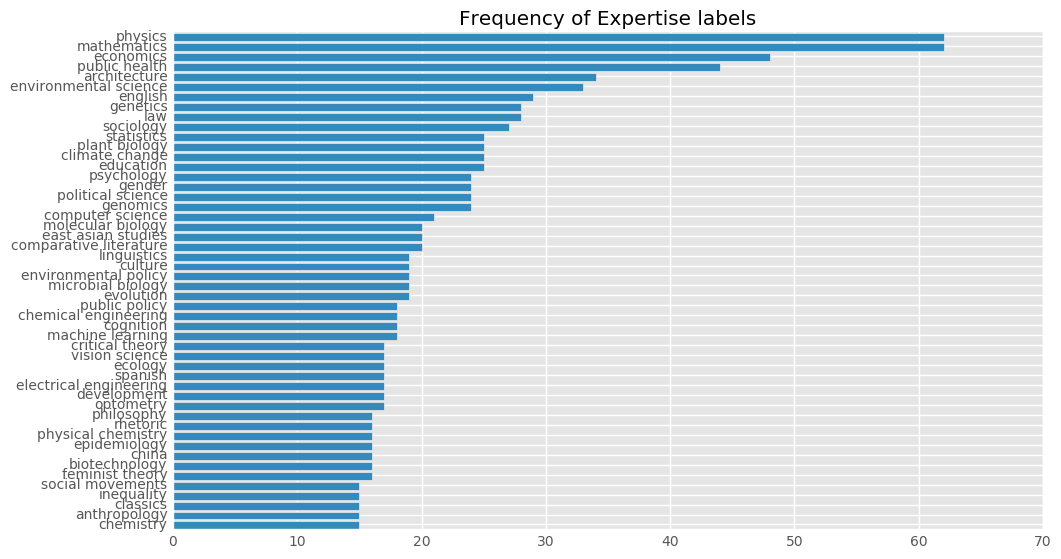

In [65]:
categories_freq = nltk.FreqDist(expertise_bag).most_common(50)[::-1]
categories = []
freqs = []

for category, freq in categories_freq:
    categories.append(category)
    freqs.append(freq)
plt.barh(range(len(categories)), freqs)
ypos = np.arange(50) + 0.5
plt.yticks(ypos, categories)
plt.title('Frequency of Expertise labels')
plt.show()

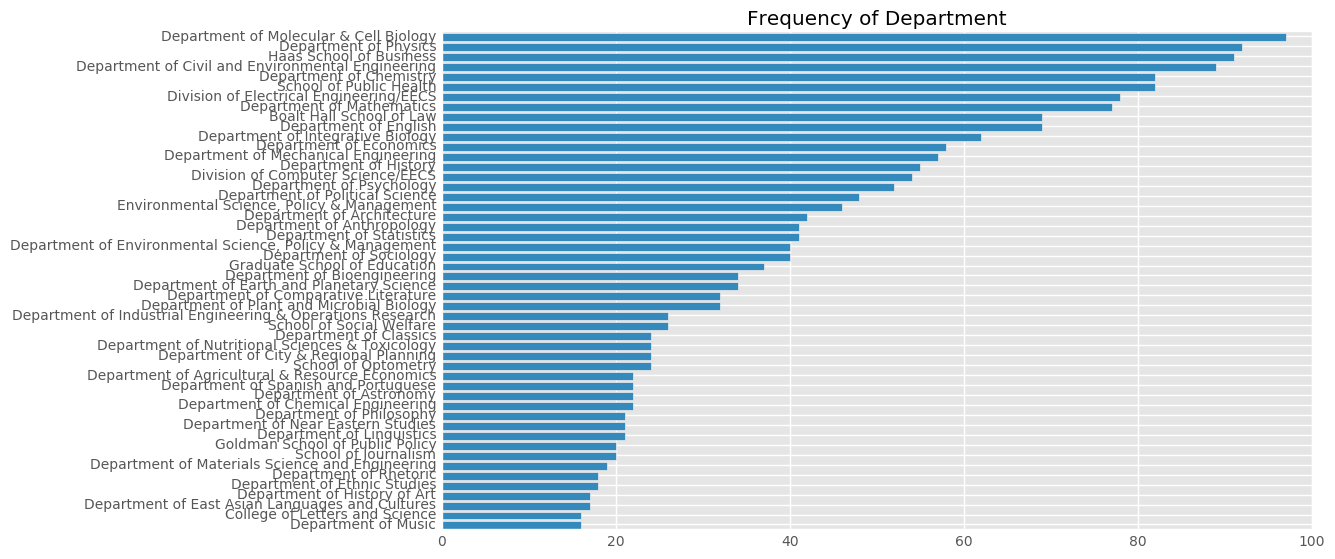

In [66]:
categories_freq = nltk.FreqDist(df_faculty['department']).most_common(50)[::-1]
categories = []
freqs = []

for category, freq in categories_freq:
    categories.append(category)
    freqs.append(freq)
plt.barh(range(len(categories)), freqs)
ypos = np.arange(50) + 0.5
plt.yticks(ypos, categories)
plt.title('Frequency of Department')
plt.show()

## What professors call themselves

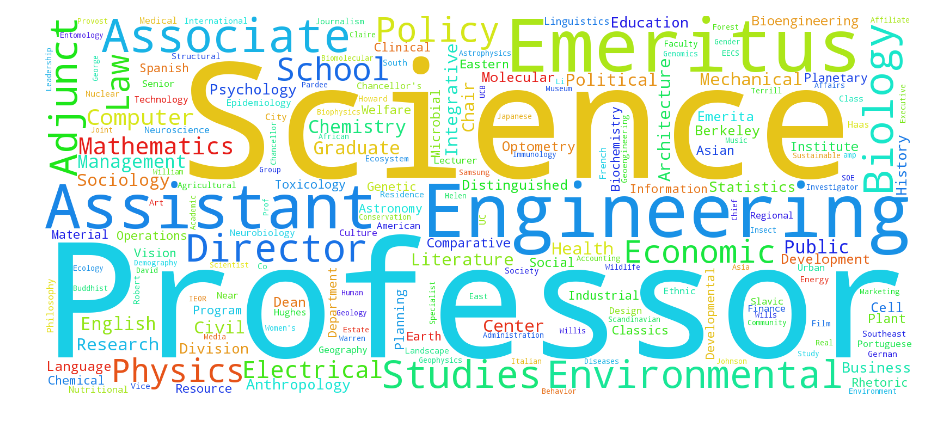

In [62]:
wc = WordCloud(background_color='white', width=1600, height=700, random_state=27)\
               .generate(' '.join(df_faculty['title_name'][~(df_faculty['title_name'].isnull())].values))
plt.axis('off')
plt.imshow(wc)
plt.show()

## Not too many faculty have research news

might be a problem if we use this data as our source of faculty profiles

In [64]:
np.mean(~df_faculty['title_of_news_1'].isnull())

0.28703296703296705

In [117]:
nb.feature_log_prob_

array([[-1.09861229, -1.09861229, -1.09861229, ..., -1.09861229,
        -1.09861229, -1.09861229],
       [-0.76013   , -2.0654553 , -2.87638552, ..., -5.87211779,
        -5.87211779, -5.87211779],
       [-2.51475961, -2.96674474, -3.12089542, ..., -4.91265489,
        -4.91265489, -4.91265489],
       ..., 
       [-2.06142304, -2.39789527, -0.74923665, ..., -4.00733319,
        -3.314186  , -4.00733319],
       [-1.84012054, -1.46751592, -3.49676005, ..., -6.08702722,
        -7.59110462, -8.2842518 ],
       [-1.29363553, -2.84296952, -2.9299809 , ..., -6.02102335,
        -6.02102335, -6.02102335]])

## nltk Naive Bayes is too slow for predicting (use sklearn instead)

In [86]:
def generate_features(title):
    title_tokens = set([w for w in nltk.word_tokenize(title.lower()) if w not in remove_words])
    features = {}
    for word in word_features:
        features['{}_present'.format(word)] = (word in title_tokens) * 1 #turn into int rather than boolean
    return features

def generate_training_sets(row):
    return generate_features(row[0]), row[1]
    
bool_filter = df['CategoryOfFundingActivity'].apply(lambda s:',' not in s)
single_category_df = df[['OpportunityTitle', 'CategoryFullTitle']][bool_filter]
single_category_df['CategoryFullTitle'] = df['CategoryFullTitle'].apply(lambda l:l[0])

model_df = single_category_df.apply(generate_training_sets, axis=1)

In [87]:
train_df = model_df[:train_set_size]
test_df = model_df[train_set_size:]

In [88]:
nb = nltk.NaiveBayesClassifier.train(train_df)

In [89]:
nb.show_most_informative_features(10)

Most Informative Features
         grantee_present = 1              Income : Health =   1742.7 : 1.0
          notice_present = 1              Region : Health =   1102.4 : 1.0
            cfda_present = 1              Educat : Scienc =   1031.7 : 1.0
         housing_present = 1              Housin : Natura =   1025.8 : 1.0
        recovery_present = 1              Recove : Educat =    924.6 : 1.0
          states_present = 1              Afford : Enviro =    796.0 : 1.0
          number_present = 1              Educat : Scienc =    703.0 : 1.0
           early_present = 1              Income : Other  =    697.3 : 1.0
          and/or_present = 1              Income : Natura =    663.8 : 1.0
        heritage_present = 1              Region : Scienc =    660.0 : 1.0


In [91]:
nltk.classify.accuracy(nb, train_df[:1000])

0.637

In [92]:
nltk.classify.accuracy(nb, test_df[:100])

0.67

## Used to turn their encoding to code

In [11]:
{w.split(' = ')[0]:w.split(' = ')[1] for w in s.split('\n') if w != ''}

{'ACA': 'Affordable Care Act',
 'AG': 'Agriculture',
 'AR': 'Arts (see "Cultural Affairs" in CFDA)',
 'BC': 'Business and Commerce',
 'CD': 'Community Development',
 'CP': 'Consumer Protection',
 'DPR': 'Disaster Prevention and Relief',
 'ED': 'Education',
 'ELT': 'Employment, Labor and Training',
 'EN': 'Energy',
 'ENV': 'Environment',
 'FN': 'Food and Nutrition',
 'HL': 'Health',
 'HO': 'Housing',
 'HU': 'Humanities (see "Cultural Affairs" in CFDA)',
 'IS': 'Information and Statistics',
 'ISS': 'Income Security and Social Services',
 'LJL': 'Law, Justice and Legal Services',
 'NR': 'Natural Resources',
 'O': 'Other (see text field entitled "Explanation of Other Category of Funding Activity" for clarification)',
 'RA': 'Recovery Act',
 'RD': 'Regional Development',
 'ST': 'Science and Technology and other Research and Development',
 'T': 'Transportation'}